In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muhammedazhar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muhammedazhar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\muhammedazhar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
df = pd.read_csv('dataset.csv', usecols = ['par_id', 'paragraph', 'has_entity', 'lexicon_count', 'difficult_words', 'last_editor_gender', 'category'])

In [43]:
df = df.dropna()

In [44]:
# Convert the 'category' column to lowercase
df['category'] = df['category'].str.lower()

In [45]:
df = df[df['has_entity'] != 'data missing']

In [46]:
missing_values = df.isnull().sum()
print(missing_values)

par_id                0
paragraph             0
has_entity            0
lexicon_count         0
difficult_words       0
last_editor_gender    0
category              0
dtype: int64


In [47]:
category_counts = df['category'].unique()
print(category_counts)

['biographies' 'artificial intelligence' 'programming' 'philosophy'
 'movies about artificial intelligence']


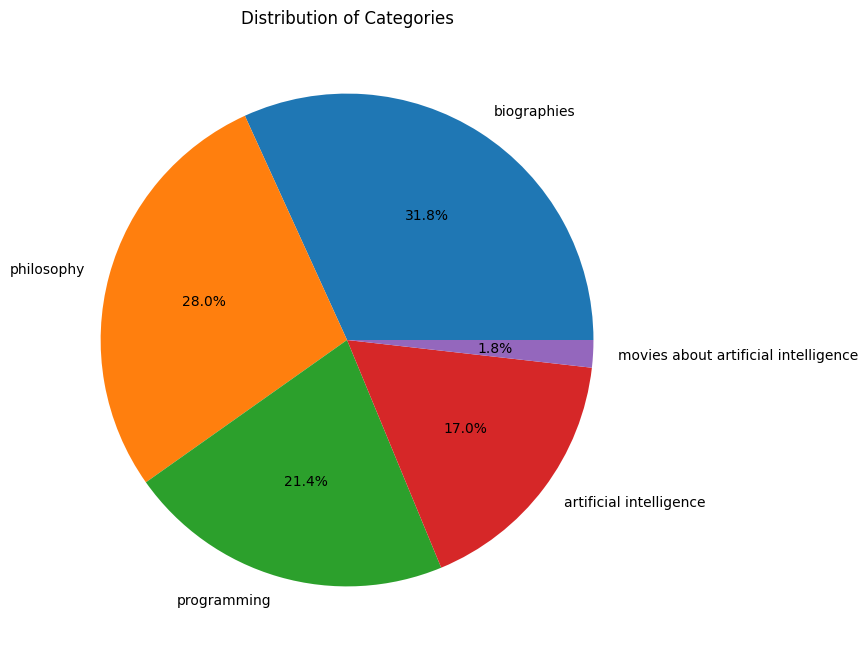

In [48]:
# Count the occurrences of each category
category_counts = df['category'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Categories')
plt.show()

In [49]:
entity_count = df['has_entity'].unique()
print(entity_count)

['ORG_YES_PRODUCT_NO_PERSON_YES_' 'ORG_YES_PRODUCT_NO_PERSON_NO_'
 'ORG_NO_PRODUCT_YES_PERSON_NO_' 'ORG_YES_PRODUCT_YES_PERSON_YES_'
 'ORG_NO_PRODUCT_NO_PERSON_NO_' 'ORG_NO_PRODUCT_YES_PERSON_YES_'
 'ORG_NO_PRODUCT_NO_PERSON_YES_' 'ORG_YES_PRODUCT_YES_PERSON_NO_']


In [50]:
category_values = df.value_counts('category')
print(category_values)

category
biographies                             2940
philosophy                              2588
programming                             1982
artificial intelligence                 1568
movies about artificial intelligence     166
Name: count, dtype: int64


In [51]:
def clean_text(text):
    # Remove punctuation marks and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 'df' DataFrame containing the 'paragraph' column
df['cleaned_paragraph'] = df['paragraph'].apply(clean_text)

In [52]:
import nltk
from nltk.tokenize import word_tokenize

# Assuming 'df' is your DataFrame containing the 'cleaned_paragraph' column
# Tokenize each paragraph and store the tokens in a new column 'tokenized_paragraph'
df['tokenized_paragraph'] = df['cleaned_paragraph'].apply(lambda x: word_tokenize(x))

# Display the first few rows to verify the tokenization
print(df[['cleaned_paragraph', 'tokenized_paragraph']].head())

                                   cleaned_paragraph  \
0  Ramsay was born in Glasgow on October He was a...   
1  It has been widely estimated for at least the ...   
2  He went on to win the Royal Medal of the Royal...   
3  The changes have altered many underlying assum...   
4  After these novels were published Disraeli dec...   

                                 tokenized_paragraph  
0  [Ramsay, was, born, in, Glasgow, on, October, ...  
1  [It, has, been, widely, estimated, for, at, le...  
2  [He, went, on, to, win, the, Royal, Medal, of,...  
3  [The, changes, have, altered, many, underlying...  
4  [After, these, novels, were, published, Disrae...  


In [53]:
# Splitting the "has_entity" column into three separate binary columns
df['ORG'] = df['has_entity'].str.contains('ORG_YES').astype(int)
df['PRODUCT'] = df['has_entity'].str.contains('PRODUCT_YES').astype(int)
df['PERSON'] = df['has_entity'].str.contains('PERSON_YES').astype(int)

# Displaying the first few rows to verify the changes
print(df[['has_entity', 'ORG', 'PRODUCT', 'PERSON']].head())

                        has_entity  ORG  PRODUCT  PERSON
0   ORG_YES_PRODUCT_NO_PERSON_YES_    1        0       1
1    ORG_YES_PRODUCT_NO_PERSON_NO_    1        0       0
2    ORG_YES_PRODUCT_NO_PERSON_NO_    1        0       0
3    ORG_NO_PRODUCT_YES_PERSON_NO_    0        1       0
4  ORG_YES_PRODUCT_YES_PERSON_YES_    1        1       1


In [54]:
X = df[['tokenized_paragraph', 'has_entity', 'ORG', 'PRODUCT', 'PERSON']]
y =df['category']
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

y = encoder.fit_transform(y)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

v = dict(zip(list(y), df['category'].to_list()))

In [55]:
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer(analyzer="word", stop_words="english")),
    ('tfidf', TfidfTransformer(use_idf=True)), 
    ('clf', MultinomialNB(alpha=.01)),
])

In [56]:
# Convert the list of tokens back into a single string per document
x_train_processed = x_train['tokenized_paragraph'].apply(' '.join)

# Now, fit your model
text_clf.fit(x_train_processed, y_train)

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.01))])

In [57]:
X_TEST = x_test['tokenized_paragraph'].to_list()
Y_TEST = list(y_test)

In [58]:
# Convert the list to a pandas Series
X_TEST_series = pd.Series(X_TEST)

# Apply the lambda function to process the data
X_TEST_processed = X_TEST_series.apply(lambda tokens: ' '.join(tokens))

# Now, use this processed data for prediction
predicted = text_clf.predict(X_TEST_processed)

In [59]:
c = 0

for doc, category in zip(X_TEST, predicted):
    
    if c == 2:break
    
    print("-"*55)
    print(doc)
    print(v[category])
    print("-"*55)

    c = c + 1 

-------------------------------------------------------
['One', 'of', 'the', 'significant', 'controversies', 'with', 'the', 'karma', 'doctrine', 'is', 'whether', 'it', 'always', 'implies', 'destiny', 'and', 'its', 'implications', 'on', 'free', 'will', 'This', 'controversy', 'is', 'also', 'referred', 'to', 'as', 'the', 'moral', 'agency', 'problem', 'the', 'controversy', 'is', 'not', 'unique', 'to', 'karma', 'doctrine', 'but', 'also', 'found', 'in', 'some', 'form', 'in', 'monotheistic', 'religionsThe', 'free', 'will', 'controversy', 'can', 'be', 'outlined', 'in', 'three', 'parts']
philosophy
-------------------------------------------------------
-------------------------------------------------------
['In', 'the', 'spring', 'of', 'he', 'visited', 'Joseph', 'Erlanger', 'at', 'Washington', 'University', 'in', 'St', 'Louis', 'who', 'told', 'him', 'he', 'would', 'take', 'Hodgkins', 'local', 'circuit', 'theory', 'of', 'nerve', 'impulse', 'propagation', 'seriously', 'if', 'he', 'could', 'show

In [60]:
np.mean(predicted == y_test)


0.9313142239048134

In [61]:
docs_new = ['Ten Months After George Floyd’s Death, Minneapolis Residents Are at War Over Policing']

In [62]:
predicted = text_clf.predict(docs_new)

In [63]:
v[predicted[0]]

'biographies'

In [64]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(text_clf,f)

In [65]:
# load
with open('model.pkl', 'rb') as f:
    clf2 = pickle.load(f)

In [66]:
docs_new = ['He went on to win the Royal Medal of the Royal Society in 1971 and the Copley Medal in 1979.']
predicted = clf2.predict(docs_new)

In [67]:
v[predicted[0]]

'biographies'